# Synthetic ice sheet

In this demo we'll run an idealized experiment inspired by the paper [*Fjord insertion into continental margins
driven by topographic steering of ice*](https://www.nature.com/articles/ngeo201) by Kessler et al. (2008).
Their work simulated the evolution of an entire ice sheet on millenial timescales, with the added twist that the bedrock topography freely evolved under the influence of erosion. We will simulate an ice sheet on a similar bedrock topography, but the bed will stay constant and we will not include erosion.

Starting with a rough guess for the initial ice thickness, we'll solve the *diagnostic equation* for the velocity throughout the ice sheet.
We'll then solve the *prognostic equation* to obtain the ice thickness at a slightly later time.
By assuming a given rate of ice accumulation and melting, we can successively solve the prognostic and diagnostic equations until the system is close to a steady state.

The whole simulation can be divided into three parts:

* Define the shape of the ice sheet and get a triangulation of the interior.
* Define the initial guess for the ice thickness and velocity, and set a value of the rheology and accumulation rate.
* Set the total simulation time and the number of time steps, and then iteratively update the ice thickness and velocity at each time step.

This is a pretty common workflow for a predictive model.

### Geometry

The model domain is a circle 250 km wide, but with a 1km-high ridge at a radius of 200 km.
This ridge is punctuated by four valleys of varying depths from which ice streams form!

In the first demo, we used one of firedrake's built-in functions to create the geometry. Here, we'll use a different built-in function to create a circular mesh.
We'll then scale the coordinates to the desired radius of 250 km.

In [1]:
import firedrake

mesh = firedrake.UnitDiskMesh(5)
R = 250e3
mesh.coordinates.dat.data[:] *= R

/home/firedrake/firedrake/lib/python3.10/site-packages/pytools/__init__.py:2484: UserWarning: unable to find git revision
  warn("unable to find git revision")


In the previous notebook, we used matplotlib to create figure and axis objects.
In this and the following notebooks, we'll instead use a wrapper function in icepack that equalizes the aspect ratio of plots and sets the axis labelling to work better for domains that are usually on the scale of hundreds of kilometers.

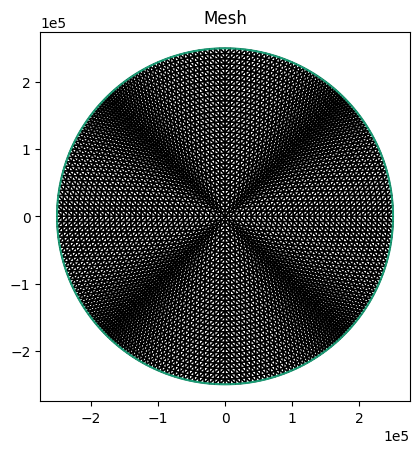

In [2]:
import icepack.plot

fig, axes = icepack.plot.subplots()
firedrake.triplot(mesh, axes=axes)
axes.set_title("Mesh");

### Input data

To create the input data for the model we need to define expressions for the ice bed, surface, thickness, velocity, and accumulation rate.
We'll then interpolate these expressions to function spaces.
One function space, $Q$, will be for scalar fields, such as elevation and ice thickness.
The second function space $V$ will be for vector fields, such as velocity.

In [3]:
Q = firedrake.FunctionSpace(mesh, family="CG", degree=2)
V = firedrake.VectorFunctionSpace(mesh, family="CG", degree=2)

To build up an expression for the bed toporaphy, we'll use the bump and ramp functions that we showed in the 0th tutorial.
The expression for the bed topography is complex and a little messy; when we wrote this tutorial in the first place, it took a few hours and lots of trial and error.
We'll show how the bed topography was built up in several stages in order to help you understand it better.
First let's define some variables and functions.

In [4]:
from firedrake import sqrt, exp, Constant

x, y = firedrake.SpatialCoordinate(mesh)
r = sqrt(x**2 + y**2)

# Plateau elevation
b_base = Constant(400)

# Max elevation
b_max = Constant(1400)

# Radius of the plateau interior
ro = 125e3

# Radius of the ridge
Ro = Constant(200e3)

def tanh(z):
    return (exp(z) - exp(-z)) / (exp(z) + exp(-z))

def θ(z):
    return (tanh(z) + 1) / 2

def sech(z):
    return 2 / (exp(z) + exp(-z))

The next step is to make a plateau on which the ice sheet will sit.

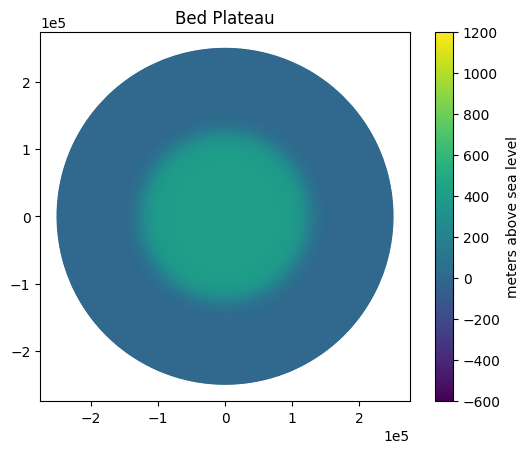

In [5]:
from firedrake import interpolate
import numpy as np

a = Constant(50e3)
ξ = (sqrt(x**2 + y**2) - ro) / a

b_expr_plateau = b_base * (1 - θ(3 * ξ))
b = interpolate(b_expr_plateau, Q)

fig, axes = icepack.plot.subplots()
kw = {"vmin": -600, "vmax": +1200}
colors = firedrake.tripcolor(b, axes=axes, **kw)
fig.colorbar(colors, label="meters above sea level")
axes.set_title("Bed Plateau");

Next we'll add a ridge that runs along the edge of the plateau.

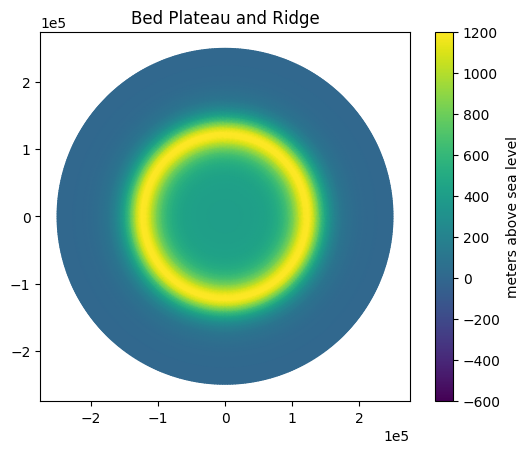

In [6]:
ζ = (r - Ro) / Ro

b_expr_ridge = (b_max - b_base) * sech(3 * ξ)
b_expr = b_expr_plateau + b_expr_ridge
b = interpolate(b_expr, Q)

fig, axes = icepack.plot.subplots()
contours = firedrake.tripcolor(b, axes=axes, **kw)
fig.colorbar(contours, label="meters above sea level")
axes.set_title("Bed Plateau and Ridge");

Finally, we'll cut valleys into the ridge to get bed topography similar to the one in Kessler et al. (2008).

In [ ]:
ρ1 = Constant(1 / 4)
μ1 = 1 - ρ1 * θ(3 * (x - ro / 4) / a) * sech(2 * y / a)

ρ2 = Constant(3 / 8)
μ2 = 1 - ρ2 * θ(3 * (y - ro / 4) / a) * sech(2 * x / a)

ρ3 = Constant(1 / 2)
μ3 = 1 - ρ3 * θ(3 * (-x + ro / 4) / a) * sech(2 * y / a)

ρ4 = Constant(5 / 8)
μ4 = 1 - ρ4 * θ(3 * (-y + ro / 4) / a) * sech(2 * x / a)

μ = μ1 * μ2 * μ3 * μ4

S = 480 / (1 - Ro / R)

b_expr_valleys = (b_max - b_base) * sech(3 * ξ) * μ - θ(5 * ζ) * S * ζ
b_expr = b_expr_plateau + b_expr_valleys
b = interpolate(b_expr, Q)

fig, axes = icepack.plot.subplots()
contours = firedrake.tripcolor(b, axes=axes, **kw)
fig.colorbar(contours, label="meters above sea level")
axes.set_title("Bed Plateau, \n Ridge, and Valleys");

Now we'll put an initial ice sheet on this bed. We'll start with one that is simply a half sphere. Though this is arbitrary and un-physical, it will allow us a starting point from which to evolve the ice sheet.

In [ ]:
from firedrake import max_value

# Surface elevation
max_radius = 195e3
dome_height = 2.4e3
dome = dome_height * max_value(1 - (x**2 + y**2) / max_radius**2, 0)
s0 = interpolate(dome, Q)

# Thickness
h0 = interpolate(max_value(s0 - b, 0), Q)

In [ ]:
fig, axes = icepack.plot.subplots()
colors = firedrake.tripcolor(s0, axes=axes)
fig.colorbar(colors, label="meters above sea level")
axes.set_title("Initial Ice \n Surface Elevation");

In [ ]:
fig, axes = icepack.plot.subplots()
colors_b = firedrake.tripcolor(b, axes=axes)
levels = np.linspace(100, 2300, 13)
contours_h = firedrake.tricontour(h0, levels, axes=axes, cmap="Blues")
fig.colorbar(colors_b, label="meters")
axes.set_title("Initial Ice Thickness Contours \n overlain on Bed Surface");

### Modeling

To actually start solving things, we need to make two objects.
First, the class `ShallowIce` represents what physics problem we plan to solve.
This class defines the equations for the shallow ice approximation, which is most applicable to parts of ice sheets and glaciers where ice flows slowly and where there is little to no sliding.
In later tutorials we'll show how to alter the components of a particular physics model and how to use other models entirely.

In [ ]:
import icepack
model = icepack.models.ShallowIce()

Second, the class `FlowSolver` decides how we're going to solve that problem.
When we initialize the flow solver we pass it any arguments that never change throughout a simulation. For this particular simulation, there are no specific arguments to pass.

In [ ]:
solver = icepack.solvers.FlowSolver(model)

The main job of the flow solver object is to solve the PDEs for ice velocity and thickness, for which it has two methods, `diagnostic_solve` and `prognostic_solve`.
These two methods are all that you need to describe the evolution of an ice sheet.

We need one more input variable, the fluidity factor $A$ in Glen's flow law $\dot\varepsilon = A\tau^3$. The fluidity depends on several variables, especially the temperature of the ice; warmer ice is easier to deform. For now we'll use a fluidity that comes from a spatially constant temperature of -5C. The code itself assumes that all temperatures are in Kelvin.

In [ ]:
T = Constant(273.15 - 5)
A = icepack.rate_factor(T)

To compute the velocity field, we'll call the diagnostic solve method of the ice sheet object.
This method takes in the thickness, surface elevation, the fluidity factor $A$, and the initial guess for the ice velocity.
In this case, we have no initial guess for the ice velocity, so we will pass it an empty function.
The keywords we use for these fields are exactly the same as their names.

In [ ]:
u0 = firedrake.Function(V)
h = h0.copy(deepcopy=True)
u = solver.diagnostic_solve(
    velocity=u0, 
    thickness=h, 
    surface=s0, 
    fluidity=A,
)

In [ ]:
fig, axes = icepack.plot.subplots()
colors = firedrake.tripcolor(u, axes=axes)
fig.colorbar(colors, label="meters / year")
axes.set_title("Initial Ice Velocity");

To evolve the ice sheet, we'll need to choose a mass balance field. Here we define a mass balance field that is by default similar to the one in Kessler et al. (2008), but we will use a mass balance field that is zero everywhere. If you'd like to experiment with the mass balance, the rest of this notebook allows the mass balance to be updated at each time step based on the surface elevation.

In [ ]:
from firedrake import min_value

def mass_balance(s, max_a=0.5, da_ds=0.5/1000, ela=300.0):
    return min_value((s - ela) * da_ds, max_a)

ela = 300.
max_a = 0.
da_ds = 0.

a = mass_balance(s0, ela=ela, max_a=max_a, da_ds=da_ds)

To project the state of the ice sheet forward in time, we'll (1) call the *prognostic solve* routine to update the ice thickness for one timestep given the accumulation rate and velocity, and (2) call the *diagnostic solve* routine to update the velocity given the current thickness.

The following code runs the model forward 500 years with a 10-year time step until the ice sheet is roughly in steady state. 
We'll save information about how much the ice thickness changes with time to later assess how close the ice sheet is to steady-state.

In [ ]:
import tqdm

dt = 10
num_timesteps = 50

dh_max = np.zeros(num_timesteps) * np.nan

for step in tqdm.trange(num_timesteps):
    a = interpolate(a, Q)
    h_old = h.copy(deepcopy=True)
    h = solver.prognostic_solve(
        dt,
        thickness=h,
        accumulation=a,
        velocity=u,
    )
    
    h.interpolate(max_value(h, 0))
    s = interpolate(h + b, Q)
    u = solver.diagnostic_solve(
        velocity=u,
        thickness=h,
        surface=s,
        fluidity=A,
    )
    a = mass_balance(s, ela=ela, max_a=max_a, da_ds=da_ds)
    dh = interpolate(h - h_old, Q)
    
    dh_max[step] = dh.dat.data_ro.max()

The main loop to run the simulation consists of alternating calls to the prognostic and diagnostic solve methods of the solver object.
We'll see this pattern repeated in all of the demos that follow.
In some cases we'll add in extra physics, like updating the temperature or damage field, but the core idea is the same.

**All of the fields involved in this simulation -- the ice thickness, velocity, and so forth -- were passed by keyword.**
Only the timestep `dt` was passed by position.
This is true more broadly of every solving routine in icepack.
Passing arguments by keyword is admittedly more verbose than passing them by position, but we've made this choice for an important reason.
As we'll show in the next demo, passing arguments by keyword makes it possible to swap out components of the model physics for your own customized versions.
This flexibility would be impossible if we passed these fields by position.
Finally, keyword arguments save you the trouble of remembering what order everything goes in; you only have to remember their names.

As a typographical convenience, we've put every argument on its own line.
This isn't strictly necessary and you can adopt whatever convention you like for indenting your own code.
We've found that using a separate line for each argument when calling really important functions makes them stand out visually, and makes it easiest to quickly scan over the argument list.

We've added a progress bar using the package [tqdm](https://tqdm.github.io/) to give a bit of feedback about how long the simulation will take.
These kinds of diagnostics are helpful to know that the simulation is actually running and that it hasn't frozen.
But you can also put in whatever extra code you want here.
For example, you might want to make plots of the thickness and velocity, print out some physical quantity like the total flux of ice out of the calving front, or accumulate the fields into a list so that you can analyze the entire time series later.

To wrap things up, we'll make some plots. 
We'll plot the final ice thickness and velocity. 
We'll also look at how much the ice thickness has changed compared to the original geometry and compared to the last time step. The latter tells us how close we are to steady-state. We will also use the saved max thickness change for each time step to look at a time series of how the ice sheet approached steady-state.

In [ ]:
fig, axes = icepack.plot.subplots()
colors = firedrake.tripcolor(u, axes=axes)
fig.colorbar(colors, label="meters / year")
axes.set_title("Final Ice Velocity");

In [ ]:
fig, axes = icepack.plot.subplots()
colors = firedrake.tripcolor(s, axes=axes)
fig.colorbar(colors, label="meters above sea level")
axes.set_title("Final Ice \n Surface Elevation");

As we can see, the velocity has evolved and now shows the highest velocities where the ice is constricted to flowing through the valleys. 
These are the ice streams!

Though the ice surface elevation visually appears to have changed only a little, looking at the current ice thickness compared to the original ice thickness gives a clearer picture of how the ice sheet geometry has evolved.

In [ ]:
fig, axes = icepack.plot.subplots()
thickness_change = interpolate(h - h0, Q)
colors = firedrake.tripcolor(
    thickness_change, vmin=-300, vmax=+300, axes=axes, cmap="RdBu"
)
fig.colorbar(colors, label="meters")
axes.set_title("Final - Initial\nIce Thickness");

If we plot the last incremental change in thickness, then we can get a better sense of how close the ice sheet is to steady-state.

In [ ]:
fig, axes = icepack.plot.subplots()
colors = firedrake.tripcolor(
    dh, vmin=-10, vmax=+10, axes=axes, cmap="RdBu"
)
fig.colorbar(colors, label="meters")
axes.set_title("Final - Previous\nIce Thickness");

Last, if we plot the maximum change in thickness through time, we can see how the ice sheet is approaching steady-state.

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(dt * np.arange(num_timesteps), dh_max)
plt.xlabel("years")
plt.ylabel("maximum change in thickness (meters)")
axes.set_title("Max Change in Ice Thickness at each Time Step");

### Conclusion

In the last demo, we saw how to create a mesh, define a finite element space, interpolate functions to that finite element space, and analyze the results.
Here we've shown how to use these functions as an input to an ice sheet using the shallow ice flow model.
If you want to experiment with this example a bit more, you can run this notebook yourself and:

* change the mass balance parameters
* change the depth of the bedrock valleys or height of the ridge
* change the initial ice sheet geometry

The mass balance parameters are in units of meters/year.
A typical accumulation rate deep in the interior of Antarctica would be on the order of 7 cm/year, whereas southeast Greenland can have rates closer to 50 cm / year to 1.5 m / year.
You can learn more about the mass balance of glaciers around the world from the [SUMup](https://essd.copernicus.org/articles/10/1959/2018/) database.
To make things even more interesting, you can try changing the accumulation rate or lapse rate as a function of time to simulate glacial cycles.